In [1]:
import librosa
import keras
import keras.layers as L
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import os
import random
import bisect

Using TensorFlow backend.


In [2]:
from segment_tree import SegmentTree
class NotesInInteval:
    num_notes = 127+1
    
    def __init__(self):
        pass
    
    @classmethod
    def load(cls, filename):
        obj = cls()
        
        ev = pd.read_csv(filename)
        notes=[]
        for i in range(len(ev["type"])):
            notes.append([ev["pitch"][i], ev["type"][i], ev["tick"][i]])
        notes = sorted(notes, key=lambda note: note[2])
        
        c = cls.num_notes
        n = int(len(notes)/2)
        
        M = [[0 for i in range(2*n)] for j in range(c)]
        bal = [0 for i in range(c)]
        obj.time = []
        for i in range(2*n):
            if(str(notes[i][1]) == 'True'):
                bal[notes[i][0]] += 1
            else:
                bal[notes[i][0]] -= 1
            M[notes[i][0]][i] = bal[notes[i][0]]
            obj.time.append(notes[i][2])
        
        obj.M_st = [SegmentTree(i) for i in M]
        
        return obj
        
    def get_notes_in_interval(self, start, stop):
        if(start > stop):
            (start, stop) = (stop, start)
        start_index = 0
        stop_index = len(self.time)-1

        if(start >= self.time[0]):
            start_index = bisect.bisect_left(self.time,
                                             self.time[bisect.bisect_right(self.time, start)-1])

        if(stop >= self.time[0]):
            stop_index = bisect.bisect_left(self.time,
                                            self.time[bisect.bisect_right(self.time, stop)-1])

        plnotes = (self.M_st[i].query(start_index, stop_index, "max") for i in range(self.num_notes))
        plnotes = [min(x, 1) for x in plnotes]

        return plnotes

In [13]:
def generate_sample(generator,spectrogram,time_step=5,hop_len = 512,sr = 22050):
    k = generator.time[-1]/(len(spectrogram[0])*hop_len)
    startMid = random.randint(generator.time[0],int(generator.time[-1]-time_step*sr*k))
    stopMid = int(startMid + time_step*sr*k)
    
    startSpectr=int(startMid/(k*hop_len))
    stopSpectr=int(startSpectr+time_step*sr/(hop_len))
    
    out1 = spectrogram[:,startSpectr:stopSpectr].transpose().reshape(1, 1, int(time_step*sr/(hop_len)),128)
    out2 = np.array(generator.get_notes_in_interval(startMid,stopMid)).reshape(1, 128)
    return out1, out2

In [3]:
time_step = 5 #seconds
hop_len = 512
sr = 22050
model=keras.models.Sequential()
model.add(L.InputLayer(input_shape=(1,int(time_step*sr/(hop_len)),128)))#128,215)))
model.add(L.Conv2D(128,(16,16), padding='same'))
model.add(L.Conv2D(128,(3,3), padding='same'))
#model.add(L.GlobalMaxPool2D())
model.add(L.Flatten())
model.add(L.Dense(512,activation='relu'))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='sigmoid'))
#model.add(L.GlobalMaxPool1D())

In [4]:
model.compile(optimizer='SGD',loss='binary_crossentropy')

In [ ]:
##load files
itAlreadyWas=False
Exceptions=[]
strange_things=[]
generators=[]
spectrograms=[]
count=0

for path, subdirs, files in os.walk('/home/jheuristic/data/wav/'):
    for file in files:
        if(itAlreadyWas):
            if(file == 'Grieg Piano Concerto op16 1mov.mid.wav'):
                itAlreadyWas=False
        else:
            successfully_loaded=True
            try:
                wavfile = file
                
                stat_info_wav=os.stat("/home/jheuristic/data/wav/"+wavfile)
                stat_info_pickle=os.stat('/home/jheuristic/data/pickles/'+wavfile[:-3]+'pckl')
                
                if(stat_info_wav.st_size < 55737036 and stat_info_pickle.st_size < 34875879):
                    y, sr = librosa.load("/home/jheuristic/data/wav/"+wavfile)
                    generator=pickle.load(open('/home/jheuristic/data/pickles/'+wavfile[:-3]+'pckl','rb'))
                    count+=1
                else:
                    successfully_loaded=False
                    
            except Exception as e:
                Exceptions.append(e)
                successfully_loaded=False

            if(successfully_loaded and max(generator.time) !=  min(generator.time)):
                spectrograms.append(librosa.feature.melspectrogram(y,sr,hop_length=hop_len))
                generators.append(generator)
                """if(len(generators)>10):
                    break"""
            elif (successfully_loaded and max(generator.time) ==  min(generator.time)):
                strange_things.append(wavfile)

In [22]:
itAlreadyWas=False
Exceptions=[]
strange_things=[]
generators=[]
spectrograms=[]
count=0

for path, subdirs, files in os.walk('/home/jheuristic/data/wav/'):
    for file in files:
        if(itAlreadyWas):
            if(file == 'Grieg Piano Concerto op16 1mov.mid.wav'):
                itAlreadyWas=False
        else:
            successfully_loaded=True
            wavfile = file
            try:
                stat_info_wav=os.stat("/home/jheuristic/data/wav/"+wavfile)
                if(stat_info_wav.st_size > 55737036):
                    os.remove("/home/jheuristic/data/wav/"+wavfile)
            except:
                pass
                
            try:
                stat_info_pickle=os.stat('/home/jheuristic/data/pickles/'+wavfile[:-3]+'pckl')
                if(stat_info_pickle.st_size > 34875879):
                    os.remove('/home/jheuristic/data/pickles/'+wavfile[:-3]+'pckl')
            except:
                pass

In [16]:
len(generators)

101

In [10]:
loss=[]

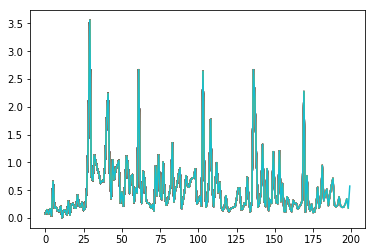

In [14]:
#%%time
##train

for counter in range(200):
    indexes=np.random.randint(0,len(generators),1)
    x_batch, y_batch = map(np.concatenate, zip(*[generate_sample(generators[i],spectrograms[i]) for i in indexes]))
    #x_batch.reshape(1,x_batch.shape)
    loss.append(model.train_on_batch(x_batch,y_batch))
    #clear_output(wait=True)
    plt.plot(loss)
    model.save_weights("/home/jheuristic/data/weights/model2.wght")

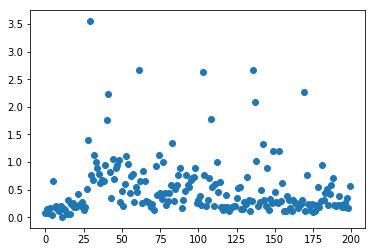

In [24]:
plt.scatter(range(len(loss)),loss)

In [26]:
np.mean(loss)

0.52363014

In [26]:
model.save_weights("/home/jheuristic/data/weights/model2.wght")

In [36]:
a,b = map(np.concatenate, zip(*[generate_sample(generators[i],spectrograms[i]) for i in indexes]))

In [52]:
a,b = generate_sample(generators[0],spectrograms[0])

In [57]:
b = model.predict(a)

In [58]:
b.shape

(1, 128)

In [6]:
model.load_weights('/home/jheuristic/data/weights/model2.wght')